# Document AI: Fine-tuning Donut for document-parsing using Hugging Face Transformers 

In this blog, you will learn how to fine-tune [Donut-base](https://huggingface.co/naver-clova-ix/donut-base) for document-understand/document-parsing using Hugging Face Transformers. Donut is a new document-understanding model achieving state-of-art performance with an MIT-license, which allows it to be used for commercial purposes compared to other models like LayoutLMv2/LayoutLMv3. 
We are going to use all of the great features from the Hugging Face ecosystem, like model versioning and experiment tracking.

1. [Setup Development Environment](#1-setup-development-environment)
2. [Load Custom dataset](#2-load-custom-dataset)
3. [Creating dataset](#3-creating-dataset)
4. [Prepare dataset for Donut](#4-prepare-dataset-for-donut)
5. [Fine-tune and evaluate Donut model](#5-fine-tune-and-evaluate-donut-model)

Before we can start, make sure you have a [Hugging Face Account](https://huggingface.co/join) to save artifacts and experiments. 

---

## Quick intro: Document Understanding Transformer (Donut) by ClovaAI

Document Understanding Transformer (Donut) is a new Transformer model for OCR-free document understanding. It doesn't require an OCR engine to process scanned documents but is achieving state-of-the-art performances on various visual document understanding tasks, such as visual document classification or information extraction (a.k.a. document parsing). 
Donut is a multimodal sequence-to-sequence model with a vision encoder ([Swin Transformer](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/swin#overview)) and text decoder ([BART](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/bart)). The encoder receives the images and computes it into an embedding, which is then passed to the decoder, which generates a sequence of tokens.

* Paper: https://arxiv.org/abs/2111.15664
* Official repo:  https://github.com/clovaai/donut

--- 
This notebook is just an adaptation of [this](https://www.philschmid.de/fine-tuning-donut) to my dataset

## 1. Setup Development Environment

Our first step is to install the Hugging Face Libraries, including transformers and datasets. Running the following cell will install all the required packages.


In [1]:
!pip install -q "transformers>=4.22.0" # comment in when version is released
!pip install -q "datasets>=2.4" sentencepiece tensorboard 

In [2]:
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

sudo: apt-get: command not found


### Hugging face login

This example will use the [Hugging Face Hub](https://huggingface.co/models) as a remote model versioning service. To be able to push our model to the Hub, you need to register on the [Hugging Face](https://huggingface.co/join). 
If you already have an account, you can skip this step. 
After you have an account, we will use the `notebook_login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk. 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load custom Dataset
We will load a version of the custom dataset from my google drive. To the google collab. And then get in the correct directory to then work with it. Also do some cleanups of useless files.

---

We also can acces the `xlsx` file

In [7]:
# from google.colab import drive
# Mount the google drive
# drive.mount('/content/drive')

# Change directory to the correct directory
%cd copy

/Users/jaczac/Github/Thesis/donut_example/copy


### Formatting the dataset lables

We import the dataset lables in the format given to us in `xlsx` and load them into a pandas dataframe to be able to work with the with more ease. We also do some cleanup by setting NaN for unlabled tags. Also somewhere around line 226 or 266 i think i had to change a Day from 26 14 to 26-14 since I'm looking for spaces to identify the days that were wrongly interpreted as dates 

In [8]:
import pandas as pd
import numpy as np

# Read the xlsx file
df = pd.read_excel('lables.xlsx')

# Select only the first 10 rows of the dataframe
# df = df.head(500)

# Replace all occurrences of 'x' with NaN
df.replace('x', np.NaN, inplace=True)

columns_to_format = ['Giorno', 'Mese', 'Anno', 'Altitudine']

# Drop the lines were an error occurs for know
for index, row in df.iterrows():
    try:
        # Loop through the different fields to which we want to apply it
        for column in columns_to_format:
            if pd.notna(row[column]):
                row[column] = pd.to_datetime(row[column], errors='coerce').strftime('%-d-%-m')
    except ValueError:
        # Drop the rows that are too wierd
        df.drop(index, inplace=True)
        
# Change the days where they where automatically formatted to dates for two different fields
for column in columns_to_format:
    df[column] = df[column].apply(lambda x: pd.to_datetime(x, errors='coerce').strftime('%-d-%-m') if (not pd.isna(x) and ' ' in str(x)) else x)

### Creating the metadata.json

We have a folder with images and we want to create the `metadata.json` file  which associate text from the dataframe to the images as ground truth. This is necessary for the `imagefolder` feature of `datasets`.

The `metadata.json` should look at the end similar to the example below.

```json
{"file_name": "0001.png", "ground_truth": "This is a golden retriever playing with a ball"}
{"file_name": "0002.png", "ground_truth": "A german shepherd"}
```

In our example will `"text"` column contain the OCR text of the image, which will later be used for creating the Donut specific format.

In [9]:
from pathlib import Path
import json
import os

# define paths
# base_path = Path("/content/drive/MyDrive/data")
# image_path = base_path.joinpath("img")
image_path = "img"


# define metadata list
metadata_list = []

# loop through rows of dataframe
for index, row in df.iterrows():
    # Do it only for the ones who have null note and others to avoid wierd things
    if pd.isnull(row['Note']) and pd.isnull(row['Determinavit']) and pd.isnull(row['Legit']):
       
        # Fill the NaN in the row wiht the empty string
        row = row.fillna(' ')
        
        # create dictionary with metadata for this row
        metadata_dict = {
            "Nome_verbatim": row['Nome_verbatim'],
            "Nome_floritaly": row['Nome_floritaly'],
            "Luogo_Raccolta": row['Località di raccolta'],
            "Altitudine": row['Altitudine'],
            "Giorno": row['Giorno'],
            "Mese": row['Mese'],
            "Anno": row['Anno'],
        }
        # create dictionary with "file_name" and "text" keys
        metadata_list.append({
            "ground_truth": json.dumps(metadata_dict),
            "file_name": f"{str(row['ID']).zfill(5)}.jpg"
        })

# write jsonline file to the image_path
jsonl_file_path = os.path.join(image_path, 'metadata.jsonl')
with open(jsonl_file_path, 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

### Delete images that are not in the metadata.json

---

After I have created a copy I can delete the images that are not in the metadata from the folder that I actually use

In [11]:
import shutil

# create a copy of the 'data' directory as 'img_copy'
# shutil.copytree('/content/drive/MyDrive/data/img', '/content/drive/MyDrive/img_copy')

metadata_file = "img/metadata.jsonl"
image_path = "img/"

# load the list of image files from metadata file
with open(metadata_file, 'r') as f:
    metadata_list = [json.loads(line)['file_name'] for line in f]

# delete image files that don't have metadata
for file_name in os.listdir(image_path):
    if file_name.endswith('.jpg') and file_name not in metadata_list:
        os.remove(os.path.join(image_path, file_name))

### Smaller image size dataset

Create a copy of the images with a half of the size and rotate them in necessary

In [39]:
from PIL import Image, ExifTags
import shutil
import os

# Define the paths for the input and output directories
input_dir = "img/"
output_dir = "img_resized/"

# Create the output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through all the image files in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg"):
        # Open the image and resize it
        with Image.open(os.path.join(input_dir, filename)) as img:
            resized_img = img.resize((2400, 1800))
            
            # Check if the image has orientation metadata and rotate it if necessary
            for orientation in ExifTags.TAGS.keys():
                if ExifTags.TAGS[orientation] == 'Orientation':
                    if hasattr(img, '_getexif'):
                        exif = dict(img._getexif().items())
                        if exif[orientation] == 3:
                            resized_img = resized_img.rotate(180, expand=True)
                        elif exif[orientation] == 6:
                            resized_img = resized_img.rotate(270, expand=True)
                        elif exif[orientation] == 8:
                            resized_img = resized_img.rotate(90, expand=True)
                    break
            
            # Save the resized image to the output directory with correct orientation metadata
            resized_img.save(os.path.join(output_dir, filename), exif=img.info.get('exif'))

# Copy the metadata file to the output directory
shutil.copyfile("img/metadata.jsonl", "img_resized/metadata.jsonl")

'img_resized/metadata.jsonl'

# Prepare train, validation, and test splits

In this code cell, we load a dataset of images and metadata from a JSONL file, and then split it into three subsets for training, validation, and testing. We use the `train_test_split` function from scikit-learn to perform the splits, with a random seed for reproducibility.

After creating the splits, we create three new directories for each subset, and move the corresponding images and metadata files into each directory. We use a loop to copy the images to the new directories, renaming them if necessary, and create new metadata files for each subset.

The resulting directory structure should be as follows:

- `img/train` contains the training images and metadata 80%
- `img/val` contains the validation images and metadata 10%
- `img/test` contains the test images and metadata 10%

The metadata files are in the JSONL format, with each line representing a dictionary containing information about each image, such as the filename, label, and other metadata.

In [40]:
import json
import os
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

image_path = "img_resized/"

# Set random seed for reproducibility
seed = 1337 

# load metadata from JSONL file
metadata_list = []
with open(os.path.join(image_path, 'metadata.jsonl'), 'r') as infile:
    for line in infile:
        metadata_list.append(json.loads(line.strip()))

# Split the dataset into train, validation and test
# I split it in 80/20 and then I split the 20 percent in half
train_metadata, temp_metadata = train_test_split(metadata_list, test_size=0.2, random_state=seed)
val_metadata, test_metadata = train_test_split(temp_metadata, test_size=0.5, random_state=seed)

# create directories
os.makedirs(os.path.join(image_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(image_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(image_path, 'test'), exist_ok=True)

# Define directories and corresponding metadata
dirs = ['train', 'val', 'test']
metadata = [train_metadata, val_metadata, test_metadata]

# Loop over directories and metadata, copy images and create metadata file
for directory, data in zip(dirs, metadata):
    metadata_list = []
    for entry in data:
        src_file_path = os.path.join(image_path, entry['file_name'])
        dst_file_path = os.path.join(image_path, directory, entry['file_name'])
        os.rename(src_file_path, dst_file_path)
        metadata_list.append(entry)
    
    with open(os.path.join(image_path, directory, 'metadata.jsonl'), 'w') as outfile:
        for entry in metadata_list:
            json.dump(entry, outfile)
            outfile.write('\n')

## 3. Creating dataset

> This is a good starting point if your dataset is already formatted correctly

Since our custom dataset is not compatible with Donut, we will use the `imagefolder` feature of the `datasets` library to load the dataset into our model. 
Now we can load the dataset using the `imagefolder` feature of `datasets`.
___

#### Notes
This might be interesting [sparrow](https://github.com/katanaml/sparrow)

In [41]:
# Delete in case of cached dataset
!rm -rf /root/.cache/huggingface/datasets/imagefolder/default-5a4ceb57f781cbf0/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f
# !rm -rf /contnt/drive/MyDrive/data/img_resized
!pwd

/Users/jaczac/Github/Thesis/donut_example/copy


In [42]:
from pathlib import Path
from datasets import load_dataset
import json

# define paths
base_path = Path("data/")
# image_path = base_path.joinpath("img")
image_path = "img_resized"

dataset = load_dataset(image_path)

print(f'this is the dataset {dataset}')

Resolving data files:   0%|          | 0/1462 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /Users/jaczac/.cache/huggingface/datasets/imagefolder/img_resized-effcf900822572a3/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

this is the dataset DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 1461
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 183
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 183
    })
})


#### Show an example

Now, lets take a closer look at our dataset by showing an example

Random sample is 141
OCR text is {"Nome_verbatim": "Equisetum ", "Nome_floritaly": "Equisetum arvense L.\n", "Luogo_Raccolta": "Monte Festa", "Altitudine": 800, "Giorno": 9, "Mese": 5.0, "Anno": 1965.0}


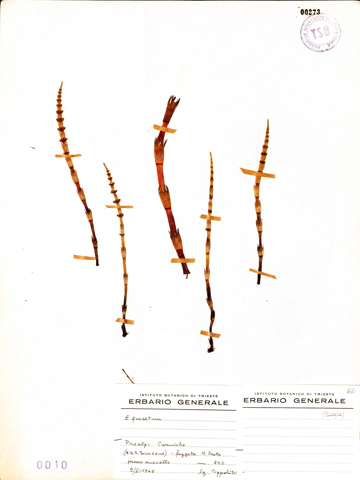

In [138]:
import random

random_sample = random.randint(0, len(dataset['train']))

example = dataset['train'][random_sample]
image = example['image']
ground_truth = example['ground_truth']
 
# Print the nmae of the sample
print(f"Random sample is {random_sample}")
        
# let's load the corresponding JSON dictionary (as string representation)
print(f"The ground_truth is {ground_truth}")

# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.2), int(height*0.2))))
# display(image)

In [46]:
from ast import literal_eval

literal_eval(ground_truth)

{'Nome_verbatim': 'Polystichum lonchitis (L.) Roth',
 'Nome_floritaly': 'Polystichum lonchitis (L.) Roth\n',
 'Luogo_Raccolta': 'Forcella di Caserata',
 'Altitudine': 1350,
 'Giorno': 14,
 'Mese': 5.0,
 'Anno': 1972.0}

## 4. Prepare dataset for Donut
> This should remain fairly similar just change the json data example

As we learned in the introduction, Donut is a sequence-to-sequence model with a vision encoder and text decoder. When fine-tuning the model we want it to generate the `"text"` based on the image we pass it. Similar to NLP tasks, we have to tokenize and preprocess the text. 
Before we can tokenize the text, we need to transform the JSON string into a Donut compatible document. 

**current JSON string**
```json
{"company": "ADVANCO COMPANY", "date": "17/01/2018", "address": "NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR", "total": "7.00"}
```

**Donut document**
```json
<s></s><s_company>ADVANCO COMPANY</s_company><s_date>17/01/2018</s_date><s_address>NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR</s_address><s_total>7.00</s_total></s>
```

To easily create those documents the ClovaAI team has created a [json2token](https://github.com/clovaai/donut/blob/master/donut/model.py#L497) method, which we extract and then apply.

In [ ]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")


Map:   0%|          | 0/358 [00:00<?, ? examples/s]

Sample: <s><s_Nome_verbatim>Lycopodium annotinum L.</s_Nome_verbatim><s_Nome_floritaly>Spinulum annotinum (L.) A.Haines subsp. annotinum
</s_Nome_floritaly><s_Mese>8.0</s_Mese><s_Luogo_Raccolta>Sella di Val Dolce, provincia di Udine</s_Luogo_Raccolta><s_Giorno>28</s_Giorno><s_Anno>2001.0</s_Anno><s_Altitudine>1850.0</s_Altitudine></s>
New special tokens: ['<s_Nome_verbatim>', '</s_Nome_verbatim>', '<s_Nome_floritaly>', '</s_Nome_floritaly>', '<s_Mese>', '</s_Mese>', '<s_Luogo_Raccolta>', '</s_Luogo_Raccolta>', '<s_Giorno>', '</s_Giorno>', '<s_Anno>', '</s_Anno>', '<s_Altitudine>', '</s_Altitudine>', '<s>', '</s>']


The next step is to tokenize our text and encode the images into tensors. Therefore we need to load `DonutProcessor`, add our new special tokens and adjust the size of the images when processing from `[1920, 2560]` to `[720, 960]` to need less memory and have faster training.

In [ ]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [1200,900] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:186: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Now, we can prepare our dataset, which we will use for the training later.


In [ ]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}
        
    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

Map:   0%|          | 0/358 [00:00<?, ? examples/s]

In [ ]:
# from datasets import load_from_disk
# from transformers import DonutProcessor

## COMMENT IN in case you want to save the processed dataset to disk in case of error later
# processed_dataset.save_to_disk("processed_dataset")
# processor.save_pretrained("processor")

## COMMENT IN in case you want to load the processed dataset from disk in case of error later
# processed_dataset = load_from_disk("processed_dataset")
# processor = DonutProcessor.from_pretrained("processor")


The last step is to split the dataset into train and validation sets.

In [ ]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

## 5. Fine-tune and evaluate Donut model

After we have processed our dataset, we can start training our model. Therefore we first need to load the [naver-clova-ix/donut-base](https://huggingface.co/naver-clova-ix/donut-base) model with the `VisionEncoderDecoderModel` class. The `donut-base` includes only the pre-trained weights and was introduced in the paper [OCR-free Document Understanding Transformer](https://arxiv.org/abs/2111.15664) by Geewok et al. and first released in [this repository](https://github.com/clovaai/donut).

In addition to loading our model, we are resizing the `embedding` layer to match newly added tokens and adjusting the `image_size` of our encoder to match our dataset. We are also adding tokens for inference later.

In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

Before we can start our training we need to define the hyperparameters (`Seq2SeqTrainingArguments`) we want to use for our training. We are leveraging the [Hugging Face Hub](https://huggingface.co/models) integration of the `Seq2SeqTrainer` to automatically push our checkpoints, logs and metrics during training into a repository.

In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-sroie"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

We can start our training by using the `train` method of the `Seq2SeqTrainer`.

In [ ]:
# Start training
trainer.train()

After our training is done we also want to save our processor to the Hugging Face Hub and create a model card. 

In [ ]:
# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()

We sucessfully trainied our model now lets test it and then evaulate accuracy of it. 

In [ ]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np

# hidde logs
transformers.logging.disable_default_handler()

# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("philschmid/donut-base-sroie")
model = VisionEncoderDecoderModel.from_pretrained("philschmid/donut-base-sroie")

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 50)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))


Nice 😍🔥 Our fine-tuned parsed the document correctly and extracted the right values. Our next step is to evalute our model on the test set. Since the model itself is a seq2seq is not that straightforward to evaluate. 

To keep things simple we will use accuracy as metric and compare the predicted value for each key in the dictionary to see if they are equal. This evaluation technique is biased/simple sincne only exact matches are truthy, e.g. if the model is not detecting a "whitespace" as in the example above it will not be counted truthy. 

In [ ]:
from tqdm import tqdm

# define counter for samples
true_counter = 0
total_counter = 0

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1

print(f"Accuracy: {(true_counter/total_counter)*100}%")

Our model achieves an accuracy of `75%` on the test set. 

_Note: The evaluation we did was very simple and only valued exact string matches as "truthy" for each key of the dictonary, is a big bias for the evaluation. Meaning that a accuracy of `75%` is pretty good._

Our first inference test is an excellent example of why this metric is biased. There the model predicted for the `address` the value `NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM` and the ground truth was `'NO. 31G&33G, JALAN SETIA INDAH X,U13/X 40170 SETIA ALAM'`, where the only difference is the ` ` whitespace in between `X` and `,U13/X`. 
In our evaluation loop, this was not counted as a truthy value.
